## Dependencies

In [1]:
# !apt-get install pypy
import os
from multiprocessing import Pool
import numpy as np
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import product
import seaborn as sns
import time

# Dense Learning EVC

## Simple static-value functions

In [11]:
def generate_task_choice_arrays(num_trials):
    '''
    Args:
    num_trials (int): number of total trials to simulate over

    Returns:
    task_choice_arrays (list of lists): all possible binary task choices for num_trials
    '''
    
    task_choice_arrays = [list(i) for i in product([0,1], repeat = num_trials)]
    
    return task_choice_arrays

def calculate_num_trials_each_task(task_choice_array, trial):
    '''
    Args:
    
        task_choice_array (1D array): task sequence currently being tested -- must be an array for np.count_nonzero() to work!
        trial (int): current trial being tested

    Returns:
        num_trials_each_task (tuple): tuple with length of the number of tasks with number of trials for each task up to 'trial'
    '''

    task0_num_trials = np.count_nonzero(task_choice_array[:trial] == 0)
    task1_num_trials = np.count_nonzero(task_choice_array[:trial] == 1)
    num_trials_each_task = (task0_num_trials, task1_num_trials)

    return num_trials_each_task

def immediate_reward_simple(task_choice_array, trial):
    '''
    Args:
    task_choice_array (1D array of 0s and 1s): pre-computed possible list of task choices
    trial (scalar): current trial (index of task_choice_array)

    Returns:
    task[n]_reward (scalar): assigned reward for task in current trial (task_choice_array[trial])

    '''
    
    current_task = task_choice_array[trial]
    
    if current_task == 0:
        return task0_reward[trial]
    elif current_task == 1:
        return task1_reward[trial]

def calculate_difficulty_simple(task_choice_array, trial):
    '''
    Args:
    task_choice_array (1D array of 0s and 1s): pre-computed possible list of task choices
    trial (int): current trial (index of task_choice_array)

    Returns:
    task[n]_difficulty (float): assigned difficulty for task in current trial (task_choice_array[trial])
    '''
    
    current_task = task_choice_array[trial]
    
    if current_task == 0:
        return task0_difficulty[trial]
    elif current_task == 1:
        return task1_difficulty[trial]

def calculate_cost_simple(task_choice_array, trial, candidate_control_signal):
    '''
    Args:
        signal (array): cognitive control signal intensity
        costParam (float, global): cost parameter per signal intensity
        
    Returns:
        controlCost (array): cost of cognitive control signal intensity
    '''

    current_task = task_choice_array[trial]
    
    if current_task == 0:
        cost_parameter = task0_cost_parameter[trial]
    elif current_task == 1:
        cost_parameter = task1_cost_parameter[trial]

    control_cost = np.exp(cost_parameter*candidate_control_signal) - 1
    
    return control_cost

def calculate_automaticity_simple(task_choice_array, trial):
    '''
    Args:
      task_choice_array (array of 0s and 1s): pre-computed possible list of task choices
      trial (int): current trial (index of task_choice_array)
      learning_rate (float, global): rate at which automaticity changes with experience

    Returns:
      automaticity (float): variable reflecting learning based on task_choice_array

      calculates based on the learning rule: 
        a_{t+1} = a_t + learning_rate
      therefore for a task with n trials:
        a_n = learning_rate * n
    '''

    current_task = task_choice_array[trial]
#     base_automaticity = 0.00001
    base_automaticity = 0.15

    num_trials_each_task = calculate_num_trials_each_task(task_choice_array, trial)
    num_trials_current_task = num_trials_each_task[current_task]

    if current_task == 0:
        learning_rate = task0_learning_rate
        base_automaticity = task0_base_automaticity
    elif current_task == 1:
        learning_rate = task1_learning_rate
        base_automaticity = task1_base_automaticity

    automaticity = learning_rate * num_trials_current_task + base_automaticity

    return automaticity 

def prob_correct_simple(task_choice_array, trial, candidate_control_signal, sigmoid_accuracy = True):
    '''
    Args:
      task_choice_array (1D array of 0s and 1s): pre-computed possible list of task choices
      trial (scalar): current trial (index of task_choice_array)
      candidate_control_signal (scalar): control signal intensity being currently probed

    Returns:
      probability_correct (scalar): probability correct based on current difficulty, automaticity and control signal

      calculates based on assumption that probability current is an exponential function of
      automaticity, difficulty and control signal between 0.5 and 1 where the exponential rate
      is determined by automaticity * candidate_control_signal scaled by difficulty

    ****could also implement a sigmoid relationship, but would need to figure out how to compensante
    for changes in scaling**** 
    '''

    automaticity = calculate_automaticity_simple(task_choice_array, trial)
    difficulty = calculate_difficulty_simple(task_choice_array, trial)

    if sigmoid_accuracy == True:
        # params if using sigmoid accuracy
        bias_adjustment = 4 # works for control signals from 0 to 25
        rate = automaticity/difficulty
        bias = bias_adjustment/rate
#         probability_correct = 0.5 + (0.5)/ (1 + np.exp(-rate*(candidate_control_signal - bias)))
        probability_correct = 1 / (1 + np.exp(-rate*(candidate_control_signal - bias)))
    else:
#         probability_correct = 1 - 0.5*np.exp(-(automaticity/difficulty) * candidate_control_signal)
        probability_correct = 1 - np.exp(-(automaticity/difficulty) * candidate_control_signal)

    return probability_correct

## Recursive parallel/sequential EVC functions

In [3]:
def get_optimal_signal(task_choice_array, trial):
    '''
    Args:
    task_choice_array (1D array of 0s and 1s): pre-computed possible list of task choices
    trial (int): current trial (index of task_choice_array)
    num_completed_trials_each_task (tuple): (number of trials completed task 0, number of trials completed task 1)

    Returns:
    optimal_control_signal (float): optimal control signal intensity based on maximum evc from candidate_evcs
    max_evc (float): maximum evc from candidate_evcs
    candidate_evcs (array): evcs for candidate_control_signals

    Note: this function is dually recursive with compute_evc()
        recursion base case is in compute_evc() when trial >= total number of trials (len(task_choice_array) - 1, because of 0 indexing)

    This function calculates the optimal control signal and the value of the maximum evc for a particular trial and task_choice_array.
    '''

    candidate_evcs = np.zeros([len(signal_range)]) # create array to keep track of EVCs
    for i, candidate_control_signal in enumerate(signal_range): # for every control signal, compute EVC for current task_choice_array at time t
        candidate_evcs[i] = compute_evc(task_choice_array, trial, candidate_control_signal)
        # print(f'candidate_evcs {candidate_evcs}')

    optimal_control_signal = signal_range[np.argmax(candidate_evcs)] # get optimal control signal by finding index of maximum EVC
    max_evc = np.max(candidate_evcs)

    return optimal_control_signal, max_evc, candidate_evcs


def compute_evc(task_choice_array, trial, candidate_control_signal):
    '''
    Args:
    task_choice_array (1D array of 0s and 1s): pre-computed possible list of task choices
    trial (int): current trial (index of task_choice_array)
    candidate_control_signal (float): control signal intensity being currently probed
    discount_factor (float, global): discount factor for future possible evcs

    Returns:
    evc (float): expected value of control given current candidate_control_signal and trial in task_choice_array

    Note: this function is dually recursive with get_optimal_signal()
        recursion base case is when trial >= total number of trials (len(task_choice_array) - 1, because of 0 indexing)
    '''

    # if computing a greedy EVC, no need for recursion
    if discount_factor == 0:
        value = immediate_reward_simple(task_choice_array, trial)
        evc = prob_correct_simple(task_choice_array, trial, candidate_control_signal) * value - calculate_cost_simple(task_choice_array, trial, candidate_control_signal)
    else:
        # recursion base case: if last trial, return last_max_evc for next_max_evc
        if trial >= len(task_choice_array) - 1:
            if task_choice_array[trial] == 1:
                next_max_evc = last_max_evc
            else:
                next_max_evc = 0
        else:
            next_optimal_control_signal, next_max_evc, _ = get_optimal_signal(task_choice_array, trial+1)
            
        value = immediate_reward_simple(task_choice_array, trial) + discount_factor * next_max_evc
        evc = prob_correct_simple(task_choice_array, trial, candidate_control_signal) * value - calculate_cost_simple(task_choice_array, trial, candidate_control_signal)

    return evc

## Main Dense EVC functions

In [4]:
def dense_evc(horizon, parallelize = True, cores = 4):
    '''
    Args:
    horizon (int): number of total trials to simulate over

    Returns:
    opt_signals (2D array): rows = task_choice_arrays, cols = trials
    max_evcs (2D array): rows = task_choice_arrays, cols = trials
    all_evcs (3D array): dim1 = task_choice_arrays, dim2 = trials, dim3 = control signal intensities

    calculate expected value of control (EVC) for num_trials over all possible binary task choices (2^num_trials possibilities)
    e.g. for num_trials = 2, possible binary task choices are: [0,0], [0,1], [1,0], [1,1]

    signal_range (global array) determines the control signal intensities over which to calculate the EVC at each step

    it's a learning EVC function because the automaticity term increases as a function of experience and affects accuracy of agent
    '''

    trials = range(horizon)
    task_choice_arrays = np.array(generate_task_choice_arrays(horizon)) # for each trial, consider all possible task choice outcomes

    # store data in these arrays
    opt_signals = np.zeros([len(task_choice_arrays), horizon]) # 2D array: rows = task_choice_arrays, cols = trials
    max_evcs = np.zeros([len(task_choice_arrays), horizon]) # 2D array: rows = task_choice_arrays, cols = trials
    all_evcs = np.zeros([len(task_choice_arrays), horizon, len(signal_range)]) # log all evcs 3D array: dim1 = task_choice_arrays, dim2 = trials, dim3 = control signal intensities

    if parallelize:
        with Pool(cores) as p:
            for trial in trials:
#                 print(f'trial {trial} started...')
                tic = time.perf_counter()
                ret = p.map(poolf, zip(task_choice_arrays, [trial]*len(task_choice_arrays)))
                opt_signals[:, trial], max_evcs[:, trial], all_evcs[:, trial, :] = zip(*ret)
                toc = time.perf_counter()
                elapsed_time = toc - tic
#                 print(f'elapsed time on trial: {elapsed_time:.4f} s = {elapsed_time/60:.2f} min = {elapsed_time/3600:.2f} hr')

    else:
        # iterate through every trial in the experiment
        for trial in trials:
            # print(f'****trial: {trial}')
        
            # for each possible task choice outcome, simulate what is going to happen
            for tca, task_choice_array in enumerate(task_choice_arrays):
                # print(f'**task choice array: {task_choice_array}')
                opt_signals[tca, trial], max_evcs[tca, trial], all_evcs[tca, trial, :] = get_optimal_signal(task_choice_array, trial)

    return opt_signals, max_evcs, all_evcs


def poolf(args):
    #print(args, *args)
    return get_optimal_signal(*args)

## Analysis Functions

In [5]:
def find_opt_task_choice_array(max_evcs):
    '''
    Args:
    max_evcs (2D array): rows = task_choice_arrays, cols = trials (max_evc values for every trial in every task_choice_array)
    Returns:
    opt_task_choice_array (1D array):  optimal task choice sequence according to the EVC theory (chosen trial by trial)
    opt_task_choice_array_idx (int): index of opt_task_choice_array in task_choice_arrays, max_evcs, etc

    find the optimal task_choice_array by locating the highest EVC value on every trial in a restricted fashion:
    e.g. if task0 has the highest EVC value on trial 1, then trial2 must choose the highest EVC among arrays that had task0 for trial 1
    '''
    num_trials = len(max_evcs[0,:])
    task_choice_arrays = np.array(generate_task_choice_arrays(num_trials))
    opt_task_choice_array = np.ones(num_trials, dtype = int) 
    for trial in range(num_trials):
        if trial == 0: # find highest EVC on first trial
            opt_task_choice_array[trial] = task_choice_arrays[np.argmax(max_evcs[:,trial])][trial]
        else: # after first trial, restrict search of highest EVC to the committed path
            matching_arrays = np.ones(len(task_choice_arrays[:,trial])) # initialize mask array
            for tca_idx in range(len(task_choice_arrays[:,trial])): # set mask to committed path so far
                matching_arrays[tca_idx] = all(opt_task_choice_array[:trial] == task_choice_arrays[tca_idx,:trial])
            opt_task_choice_array[trial] = task_choice_arrays[np.argmax(max_evcs[:,trial]*matching_arrays)][trial] # restrict search of highest EVC to committed path with mask array
        opt_task_choice_array_idx = task_choice_arrays.tolist().index(opt_task_choice_array.tolist()) # find index of optimal task choice array
  
    return opt_task_choice_array, opt_task_choice_array_idx

def calculate_performance_for_tca(task_choice_array, signals):
    '''
    Args:
      task_choice_array (1D array): array indicating task choices (task 0 or 1) for every trial of experiment
      signals (1D array): array of same shape as task_choice_array that has control signals for each task choice
    Returns:
      pr_corr (1D array): array with accuracy for every trial given task choice array and control signals
      value (1D array): array with value (accuracy * reward) for every trial given task choice array and control signals
      cost (1D array): array with cost for every trial given task choice array and control signals
    '''
    pr_corr = np.zeros(len(task_choice_array), dtype = float)
    expected_reward = np.zeros(len(task_choice_array), dtype = float)
    cost = np.zeros(len(task_choice_array), dtype = float)
    
    for t, trial in enumerate(task_choice_array):
        pr_corr[t] = prob_correct_simple(task_choice_array, t, signals[t])
        reward = immediate_reward_simple(task_choice_array, t)
        expected_reward[t] = pr_corr[t]*reward
        cost[t] = calculate_cost_simple(task_choice_array, t, signals[t])
        
    return pr_corr, expected_reward, cost

## Simulate dense Learning EVC

#### Set parameters

In [88]:
# Key Parameters:

horizon = 6 # total number of trials
discount_factor = 0.9 # discount factor for future evc values, 'gamma'
last_max_evc = 0. # base case evc, if not 0, then equivalent to a "bonus" at the end of the experiment
signal_range = np.linspace(0,10,11) # np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])


# Static task (task S)

task0_learning_rate = 0.
task0_base_automaticity = 0.15
task0_reward = np.full(horizon, 100)
task0_difficulty = np.full(horizon, 0.25)
task0_cost_parameter = np.full(horizon, 0.475)


# Learnable task (task L)

task1_learning_rate = 0.15 # learning rate, 'alpha'
task1_base_automaticity = 0.1
task1_reward = np.full(horizon, 100)
task1_difficulty = np.full(horizon, 0.25)
task1_cost_parameter = np.full(horizon, 0.475)

#### Run simulation

In [87]:
# run simulation

tic = time.perf_counter()

opt_signals, max_evcs, all_evcs = dense_evc(horizon, parallelize = True, cores = 32)

toc = time.perf_counter()
elapsed_time = toc - tic
print(f'elapsed time: {elapsed_time:.04f} s')
print(' ')

opt_task_choice_array, opt_task_choice_array_idx = find_opt_task_choice_array(max_evcs)

print(f'opt_task_choice_array = {opt_task_choice_array}')
print(f'opt_task_choice_array signals = {opt_signals[opt_task_choice_array_idx,:]}')
print(f'opt_signals task0 = {opt_signals[0,:]}')
print(f'opt_signals task1 = {opt_signals[-1,:]}')
print(f'max_evcs task0 = {max_evcs[0,:]}')
print(f'max_evcs task1 = {max_evcs[-1,:]}')
print(' ')

tcas = np.array(generate_task_choice_arrays(horizon))

print(f'tcas[0] = {tcas[0]}')
print(f'tcas[-1] = {tcas[-1]}')

pr_corr_task0, expected_reward_task0, cost_task0 = calculate_performance_for_tca(tcas[0], opt_signals[0,:])
pr_corr_task1, expected_reward_task1, cost_task1 = calculate_performance_for_tca(tcas[-1], opt_signals[-1,:])

print(f'pr_corr_task0 = {pr_corr_task0}')
print(f'expected_reward_task0 = {expected_reward_task0}')
print(f'cost_task0 = {cost_task0}')
print(f'pr_corr_task1 = {pr_corr_task1}')
print(f'expected_reward_task1 = {expected_reward_task1}')
print(f'cost_task1 = {cost_task1}')

expected_cum_reward_task0 = np.cumsum(expected_reward_task0)
expected_cum_reward_task1 = np.cumsum(expected_reward_task1)

print(f'expected_cum_reward_task0 = {expected_cum_reward_task0}')
print(f'expected_cum_reward_task1 = {expected_cum_reward_task1}')

elapsed time: 4.1958 s
 
opt_task_choice_array = [1 1 1 1 1]
opt_task_choice_array signals = [9. 7. 5. 4. 3.]
opt_signals task0 = [8. 8. 8. 8. 7.]
opt_signals task1 = [9. 7. 5. 4. 3.]
max_evcs task0 = [61.00750707 57.50815497 51.87291902 42.79812938 28.18440109]
max_evcs task1 = [ 70.31432707 279.8131761  246.53055117 178.86169438  95.62929866]
 
tcas[0] = [0 0 0 0 0]
tcas[-1] = [1 1 1 1 1]
pr_corr_task0 = [0.68997448 0.68997448 0.68997448 0.68997448 0.549834  ]
expected_reward_task0 = [68.99744811 68.99744811 68.99744811 68.99744811 54.98339973]
cost_task0 = [43.70118449 43.70118449 43.70118449 43.70118449 26.79899864]
pr_corr_task1 = [0.40131234 0.95257413 0.98201379 0.99183743 0.98787157]
expected_reward_task1 = [40.13123399 95.25741268 98.201379   99.18374288 98.7871565 ]
cost_task1 = [70.88013931 26.79899864  9.75101319  5.68589444  3.15785784]
expected_cum_reward_task0 = [ 68.99744811 137.99489623 206.99234434 275.98979245 330.97319218]
expected_cum_reward_task1 = [ 40.13123399 1

## Figure 1: Learning EVC Optimization Problem

### Plot figure

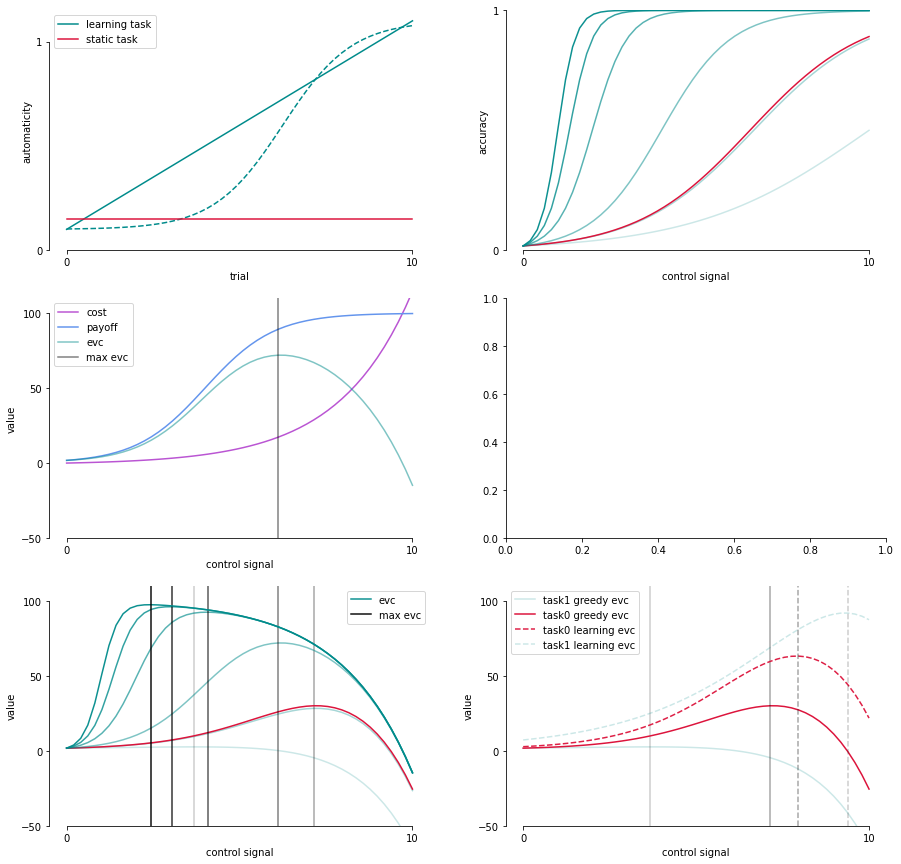

In [42]:
# ~~~~~~~~~~~~~ Instantaneous (greedy) EVC parameters parameters ~~~~~~~~~~~~~

difficulty = 0.25
reward = 100
control = np.linspace(0, 10, 50)
automaticity = np.array([0.1, 0.15, 0.25, 0.5, 0.75, 1.])

# ~~~~~~~~~~~~~ Figure 1 ~~~~~~~~~~~~~

fig, ax = plt.subplots(3,2, figsize = (15, 15))

# ~~~~~~~~~~~~~ Panel (0,0) ~~~~~~~~~~~~~

end_time = 10
time_ = np.linspace(0,end_time,50)
difficulty = 0.25

# sigmoid learning
rate = 1
bias = end_time/2 + difficulty*5
autom_sig = 0.1 + 1 / (1 + np.exp(-rate*(time_ - bias)))

# linear learning
linear_learning_rate = 0.1
autom_lin = linear_learning_rate*time_ + 0.1

# no learning
autom_flat = 0*time_ + 0.15

ax[0,0].plot(time_, autom_sig, c = 'darkcyan', linestyle = '--')
ax[0,0].plot(time_, autom_lin, c = 'darkcyan', label = 'learning task')
ax[0,0].plot(time_, autom_flat, c = 'crimson', label = 'static task')
ax[0,0].set_xticks([0,10])
ax[0,0].set_yticks([0,1])
ax[0,0].set_xlabel('trial')
ax[0,0].set_ylabel('automaticity')
ax[0,0].legend()


# ~~~~~~~~~~~~~ Panel(0,1) ~~~~~~~~~~~~~

cost = 0.475 #cost_param[3]
control_cost = np.exp(cost*control) - 1 # subtract one so that with control of 0, control_cost = 0

for i,a in enumerate(automaticity):
    rate = a/difficulty
    bias = bias_adjustment/rate
    # probability_correct = 0.5 + (0.5)/ (1 + np.exp(-rate*(candidate_control_signal - bias)))
    probability_correct = 1 / (1 + np.exp(-rate*(control - bias)))
    payoff = reward * probability_correct
    
    evc = payoff - control_cost
    max_evc_idx = np.argmax(evc)
    max_evc_ctrl = control[max_evc_idx]
    ax[0,1].plot(control, probability_correct, c = 'darkcyan', alpha = alpha[i])

    if i == 1:
        autom = a + 0.0025
        rate = autom/difficulty
        bias = bias_adjustment/rate
        probability_correct = 1 / (1 + np.exp(-rate*(control - bias)))
        payoff = reward * probability_correct
        evc = payoff - control_cost
        max_evc_idx = np.argmax(evc)
        max_evc_ctrl = control[max_evc_idx]
        ax[0,1].plot(control, probability_correct, c = 'crimson') #, linestyle = (0, (5, 10)))

ax[0,1].set_ylim((0,1))
ax[0,1].set_yticks((0,.50,1))
ax[0,1].set_yticks((0,1))
ax[0,1].set_xticks((0,10))
ax[0,1].set_ylabel('accuracy')
ax[0,1].set_xlabel('control signal')


# ~~~~~~~~~~~~~ Panel (1,0) ~~~~~~~~~~~~~

index = 2
a = automaticity[index]
rate = a/difficulty
bias = bias_adjustment/rate
# probability_correct = 0.5 + (0.5)/ (1 + np.exp(-rate*(candidate_control_signal - bias)))
probability_correct = 1 / (1 + np.exp(-rate*(control - bias)))
payoff = reward * probability_correct
evc = payoff - control_cost
max_evc_idx = np.argmax(evc)
max_evc_ctrl = control[max_evc_idx]


ax[1,0].plot(control, control_cost, c = 'mediumorchid', label = 'cost')
ax[1,0].plot(control, payoff, label = 'payoff', c = 'cornflowerblue')
ax[1,0].plot(control,evc, c = 'darkcyan', alpha = alpha[index], label = 'evc')
ax[1,0].axvline(max_evc_ctrl, alpha = alpha[index], c = 'k', label = 'max evc')# ,linestyle = '--')
    

ax[1,0].set_ylim((-50,110))
ax[1,0].set_yticks((-50,0,50,100))
ax[1,0].set_xticks((0,10))
ax[1,0].set_ylabel('value')
ax[1,0].set_xlabel('control signal')
ax[1,0].legend()


# ~~~~~~~~~~~~~ Panel (2,0) ~~~~~~~~~~~~~


for i,a in enumerate(automaticity):
    rate = a/difficulty
    bias = bias_adjustment/rate
    # probability_correct = 0.5 + (0.5)/ (1 + np.exp(-rate*(candidate_control_signal - bias)))
    probability_correct = 1 / (1 + np.exp(-rate*(control - bias)))
    payoff = reward * probability_correct
    
    evc = payoff - control_cost
    max_evc_idx = np.argmax(evc)
    max_evc_ctrl = control[max_evc_idx]
    if i == len(automaticity)-1:
        ax[2,0].plot(control,evc, c = 'darkcyan', alpha = alpha[i], label = 'evc')
        ax[2,0].axvline(max_evc_ctrl, alpha = alpha[i], c = 'k', label = 'max evc')# ,linestyle = '--')
    else:
        ax[2,0].plot(control,evc, c = 'darkcyan', alpha = alpha[i])
        ax[2,0].axvline(max_evc_ctrl, alpha = alpha[i], c = 'k')# ,linestyle = '--')
        
        # non-learning task dotted line
        if i == 1:
            autom = a + 0.0025
            rate = autom/difficulty
            bias = bias_adjustment/rate
            probability_correct = 1 / (1 + np.exp(-rate*(control - bias)))
            payoff = reward * probability_correct
            evc = payoff - control_cost
            max_evc_idx = np.argmax(evc)
            max_evc_ctrl = control[max_evc_idx]
            ax[2,0].plot(control,evc, c = 'crimson') #, linestyle = (0, (5, 10)))


ax[2,0].set_ylim((-50,110))
ax[2,0].set_yticks((-50,0,50,100))
ax[2,0].set_xticks((0,10))
ax[2,0].set_ylabel('value')
ax[2,0].set_xlabel('control signal')

# ax[1,1].set_title(f'EVC (cost_param = {cost}, diff = {difficulty} autom = {list(automaticity)}, bias_adj = {bias_adjustment})')
    
ax[2,0].legend()

# ~~~~~~~~~~~~~ Panel (2,1) ~~~~~~~~~~~~~


for i,a in enumerate(automaticity):
    if i == 0:
        rate = a/difficulty
        bias = bias_adjustment/rate
        # probability_correct = 0.5 + (0.5)/ (1 + np.exp(-rate*(candidate_control_signal - bias)))
        probability_correct = 1 / (1 + np.exp(-rate*(control - bias)))
        payoff = reward * probability_correct

        evc = payoff - control_cost
        max_evc_idx = np.argmax(evc)
        max_evc_ctrl = control[max_evc_idx]
        
        ax[2,1].plot(control,evc, c = 'darkcyan', alpha = alpha[i], label = 'task1 greedy evc')
        ax[2,1].axvline(max_evc_ctrl, alpha = alpha[i], c = 'k')# ,linestyle = '--'
        
    elif i == 1:
        autom = a + 0.0025 # adjust automaticity for slight offset for plotting purposes
        rate = autom/difficulty
        bias = bias_adjustment/rate
        probability_correct = 1 / (1 + np.exp(-rate*(control - bias)))
        payoff = reward * probability_correct
        evc = payoff - control_cost
        max_evc_idx = np.argmax(evc)
        max_evc_ctrl = control[max_evc_idx]
        ax[2,1].plot(control,evc, c = 'crimson', label = 'task0 greedy evc') #, linestyle = (0, (5, 10)))
        ax[2,1].axvline(max_evc_ctrl, alpha = alpha[i], c = 'k')

# simulation lines

end_time = 10
time_ = np.linspace(0,end_time,50)

interp_task0 = interp1d(signal_range, all_evcs[0,0,:], kind = 'cubic') # interpolate values for plotting purposes
evc_task0 = interp_task0(time_)

interp_task1 = interp1d(signal_range, all_evcs[-1,0,:], kind = 'cubic') # interpolate values for plotting purposes
evc_task1 = interp_task1(time_)

max_evc_idx_task0 = np.argmax(evc_task0)
max_evc_idx_task1 = np.argmax(evc_task1)
max_evc_ctrl_task0 = control[max_evc_idx_task0]
max_evc_ctrl_task1 = control[max_evc_idx_task1]
                      
ax[2,1].plot(control, evc_task0, c = 'crimson', alpha = alpha[-1], linestyle = '--', label = 'task0 learning evc')
ax[2,1].axvline(max_evc_ctrl_task0, linestyle = '--', alpha = alpha[1], c = 'k')
ax[2,1].plot(control, evc_task1, c = 'darkcyan', alpha = alpha[0], linestyle = '--', label = 'task1 learning evc') # task1 with nonzero discount factor
ax[2,1].axvline(max_evc_ctrl_task1, linestyle = '--', alpha = alpha[0], c = 'k')


ax[2,1].set_ylim((-50,110))
ax[2,1].set_yticks((-50,0,50,100))
ax[2,1].set_xticks((0,10))
ax[2,1].set_ylabel('value')
ax[2,1].set_xlabel('control signal')

# ax[1,1].set_title(f'EVC (cost_param = {cost}, diff = {difficulty} autom = {list(automaticity)}, bias_adj = {bias_adjustment})')
    
ax[2,1].legend()


# ~~~~~~~~~~~~~ General Figure Settings ~~~~~~~~~~~~~

sns.despine(trim=True)
# fig.savefig('./fig_modeldescription.pdf')
fig.show()

## Figure 2: Learning EVC Process Model

### Plot

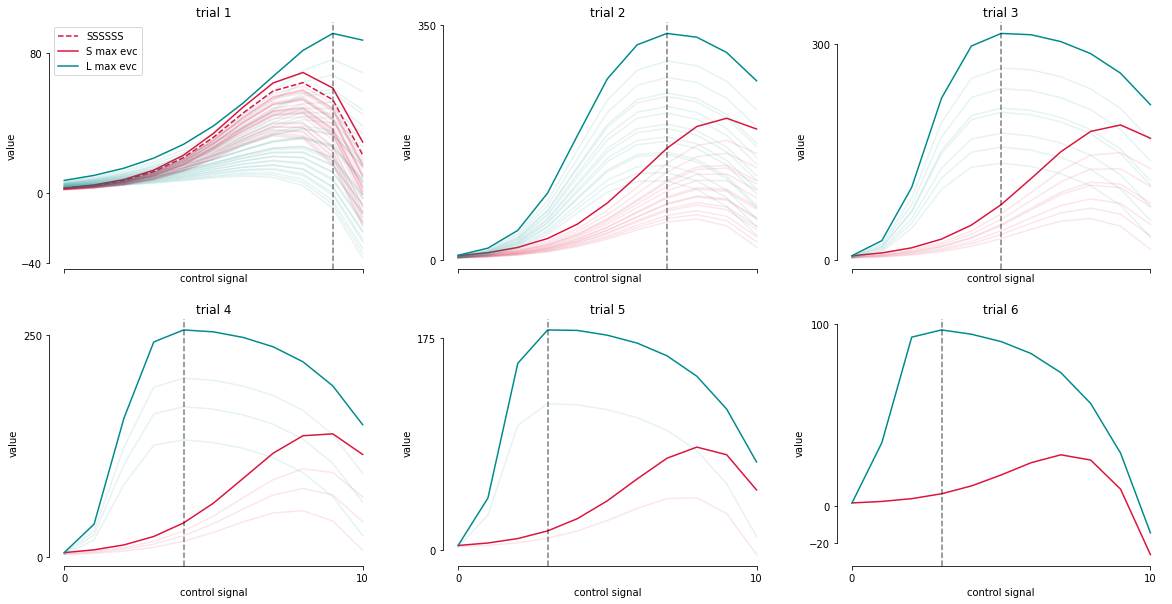

In [52]:
fig, ax = plt.subplots(2,3, figsize = (20, 10), sharex = True)

total_trials = 64

trial = 0
          
for i in range(total_trials):
    if i < int(total_trials/2):
        if i == 31:
            ax[0,0].plot(all_evcs[i,trial,:], c = 'crimson', alpha = 1, label = 'S max evc')
#             ax[0,0].axvline(np.argmax(all_evcs[i,trial,:]), c = 'k', alpha = 0.5, linestyle = '--')
        elif i == 0:
            ax[0,0].plot(all_evcs[i,trial,:], c = 'crimson', alpha = 1, linestyle = '--', label = 'SSSSSS')
#             ax[0,0].axvline(np.argmax(all_evcs[i,trial,:]), c = 'k', alpha = 0.5, linestyle = '--')
        
        else:
            ax[0,0].plot(all_evcs[i,trial,:], c = 'crimson', alpha = 0.1)
    else:
        if i == 63:
            ax[0,0].plot(all_evcs[i,trial,:], c = 'darkcyan', alpha = 1, label = 'L max evc')
            ax[0,0].axvline(np.argmax(all_evcs[i,trial,:]), c = 'k', alpha = 0.5, linestyle = '--')
        else:
            ax[0,0].plot(all_evcs[i,trial,:], c = 'darkcyan', alpha = 0.1)


trial = 1
        
for i in range(int(total_trials/2), total_trials):
    if i < int(total_trials/2 + total_trials/4):
        pass
        if i == 47:
            ax[0,1].plot(all_evcs[i,trial,:], c = 'crimson', alpha = 1)
#             ax[0,1].axvline(np.argmax(all_evcs[i,trial,:]), c = 'k', alpha = 0.5, linestyle = '--')
        
        else:
            ax[0,1].plot(all_evcs[i,trial,:], c = 'crimson', alpha = 0.1)
    else:
        if i == 63:
            ax[0,1].plot(all_evcs[i,trial,:], c = 'darkcyan', alpha = 1)
            ax[0,1].axvline(np.argmax(all_evcs[i,trial,:]), c = 'k', alpha = 0.5, linestyle = '--')
        else:
            ax[0,1].plot(all_evcs[i,trial,:], c = 'darkcyan', alpha = 0.1)
            
trial = 2
        
for i in range(int(total_trials/2 + total_trials/4), total_trials):
    if i < int(total_trials/2 + total_trials/4 + total_trials/8):
        pass
        if i == 55:
            ax[0,2].plot(all_evcs[i,trial,:], c = 'crimson', alpha = 1)
#             ax[1,0].axvline(np.argmax(all_evcs[i,trial,:]), c = 'k', alpha = 0.5, linestyle = '--')
        else:
            ax[0,2].plot(all_evcs[i,trial,:], c = 'crimson', alpha = 0.1)
    else:
        if i == 63:
            ax[0,2].plot(all_evcs[i,trial,:], c = 'darkcyan', alpha = 1)
            ax[0,2].axvline(np.argmax(all_evcs[i,trial,:]), c = 'k', alpha = 0.5, linestyle = '--')
        else:
            ax[0,2].plot(all_evcs[i,trial,:], c = 'darkcyan', alpha = 0.1)
    ax[1,0].set_ylabel('value')
            
trial = 3
        
for i in range(int(total_trials/2 + total_trials/4 + total_trials/8), total_trials):
    if i < int(total_trials/2 + total_trials/4 + total_trials/8 + total_trials/16):
        pass
        if i == 59:
            ax[1,0].plot(all_evcs[i,trial,:], c = 'crimson', alpha = 1)
#             ax[1,1].axvline(np.argmax(all_evcs[i,trial,:]), c = 'k', alpha = 0.5, linestyle = '--')
        else:
            ax[1,0].plot(all_evcs[i,trial,:], c = 'crimson', alpha = 0.1)
    else:
        if i == 63:
            ax[1,0].plot(all_evcs[i,trial,:], c = 'darkcyan', alpha = 1)
            ax[1,0].axvline(np.argmax(all_evcs[i,trial,:]), c = 'k', alpha = 0.5, linestyle = '--')
        else:
            ax[1,0].plot(all_evcs[i,trial,:], c = 'darkcyan', alpha = 0.1)
            
trial = 4
        
for i in range(int(total_trials/2 + total_trials/4 + total_trials/8 + total_trials/16), total_trials):
    if i < int(total_trials/2 + total_trials/4 + total_trials/8 + total_trials/16 + total_trials/32):
        pass
        if i == 61:
            ax[1,1].plot(all_evcs[i,trial,:], c = 'crimson', alpha = 1)
#             ax[2,0].axvline(np.argmax(all_evcs[i,trial,:]), c = 'k', alpha = 0.5, linestyle = '--')
        else:
            ax[1,1].plot(all_evcs[i,trial,:], c = 'crimson', alpha = 0.1)
    else:
        if i == 63:
            ax[1,1].plot(all_evcs[i,trial,:], c = 'darkcyan', alpha = 1)
            ax[1,1].axvline(np.argmax(all_evcs[i,trial,:]), c = 'k', alpha = 0.5, linestyle = '--')
        else:
            ax[1,1].plot(all_evcs[i,trial,:], c = 'darkcyan', alpha = 0.1)
            
trial = 5
        
for i in range(int(total_trials/2 + total_trials/4 + total_trials/8 + total_trials/16 + total_trials/32), total_trials):
    if i < int(total_trials/2 + total_trials/4 + total_trials/8 + total_trials/16 + total_trials/32 + total_trials/64):
        pass
        if i == 62:
            ax[1,2].plot(all_evcs[i,trial,:], c = 'crimson', alpha = 1)
#             ax[2,1].axvline(np.argmax(all_evcs[i,trial,:]), c = 'k', alpha = 0.5, linestyle = '--')
        else:
            ax[1,2].plot(all_evcs[i,trial,:], c = 'crimson', alpha = 0.1)
    else:
        if i == 63:
            ax[1,2].plot(all_evcs[i,trial,:], c = 'darkcyan', alpha = 1)
            ax[1,2].axvline(np.argmax(all_evcs[i,trial,:]), c = 'k', alpha = 0.5, linestyle = '--')
        else:
            ax[1,2].plot(all_evcs[i,trial,:], c = 'darkcyan', alpha = 0.1)
            
            
ax[0,0].legend()
ax[0,0].set_yticks([-40,0,80])
ax[0,0].set_xticks([0,10])
ax[0,0].set_ylabel('value')
ax[0,0].set_xlabel('control signal')
ax[0,0].set_title('trial 1')

ax[0,1].set_yticks([0,350])
ax[0,1].set_xticks([0,10])
ax[0,1].set_ylabel('value')
ax[0,1].set_xlabel('control signal')
ax[0,1].set_title('trial 2')

ax[0,2].set_yticks([0,300])
ax[0,2].set_xticks([0,10])
ax[0,2].set_ylabel('value')
ax[0,2].set_xlabel('control signal')
ax[0,2].set_title('trial 3')

ax[1,0].set_yticks([0,250])
ax[1,0].set_xticks([0,10])
ax[1,0].set_ylabel('value')
ax[1,0].set_xlabel('control signal')
ax[1,0].set_title('trial 4')

ax[1,1].set_yticks([0,175])
ax[1,1].set_xticks([0,10])
ax[1,1].set_ylabel('value')
ax[1,1].set_xlabel('control signal')
ax[1,1].set_title('trial 5')

ax[1,2].set_yticks([-20,0,100])
ax[1,2].set_xticks([0,10])
ax[1,2].set_ylabel('value')
ax[1,2].set_xlabel('control signal')
ax[1,2].set_title('trial 6')
            
sns.despine(trim='True')
fig.savefig('fig_processmodel.pdf')
fig.show()

## Figure 3: Value of Learning

#### Run simulation with gamma = 0

In [46]:
# Key Parameters:

horizon = 6 # total number of trials
discount_factor = 0. # discount factor for future evc values, 'gamma'
last_max_evc = 0. # base case evc, if not 0, then equivalent to a "bonus" at the end of the experiment
signal_range = np.linspace(0,10,11) # np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])


# Static task (task S)

task0_learning_rate = 0.
task0_base_automaticity = 0.15
task0_reward = np.full(horizon, 100)
task0_difficulty = np.full(horizon, 0.25)
task0_cost_parameter = np.full(horizon, 0.475)


# Learnable task (task L)

task1_learning_rate = 0.15 # learning rate, 'alpha'
task1_base_automaticity = 0.1
task1_reward = np.full(horizon, 100)
task1_difficulty = np.full(horizon, 0.25)
task1_cost_parameter = np.full(horizon, 0.475)

# run simulation

tic = time.perf_counter()

opt_signals_zerogamma, max_evcs_zerogamma, all_evcs_zerogamma = dense_evc(horizon, parallelize = True, cores = 32)

toc = time.perf_counter()
elapsed_time = toc - tic
print(f'elapsed time: {elapsed_time:.04f} s')
print(' ')

opt_task_choice_array_zerogamma, opt_task_choice_array_idx_zerogamma = find_opt_task_choice_array(max_evcs_zerogamma)

print(f'opt_task_choice_array = {opt_task_choice_array_zerogamma}')
print(f'opt_task_choice_array signals = {opt_signals_zerogamma[opt_task_choice_array_idx_zerogamma,:]}')
print(f'opt_signals task0 = {opt_signals_zerogamma[0,:]}')
print(f'opt_signals task1 = {opt_signals_zerogamma[-1,:]}')
print(f'max_evcs task0 = {max_evcs_zerogamma[0,:]}')
print(f'max_evcs task1 = {max_evcs_zerogamma[-1,:]}')
print(' ')

tcas = np.array(generate_task_choice_arrays(horizon))

print(f'tcas[0] = {tcas[0]}')
print(f'tcas[-1] = {tcas[-1]}')

pr_corr_task0_zerogamma, expected_reward_task0_zerogamma, cost_task0_zerogamma = calculate_performance_for_tca(tcas[0], opt_signals_zerogamma[0,:])
pr_corr_task1_zerogamma, expected_reward_task1_zerogamma, cost_task1_zerogamma = calculate_performance_for_tca(tcas[-1], opt_signals_zerogamma[-1,:])

print(f'pr_corr_task0 = {pr_corr_task0_zerogamma}')
print(f'expected_reward_task0 = {expected_reward_task0_zerogamma}')
print(f'cost_task0 = {cost_task0_zerogamma}')
print(f'pr_corr_task1 = {pr_corr_task1_zerogamma}')
print(f'expected_reward_task1 = {expected_reward_task1_zerogamma}')
print(f'cost_task1 = {cost_task1_zerogamma}')

expected_cum_reward_task0_zerogamma = np.cumsum(expected_reward_task0_zerogamma)
expected_cum_reward_task1_zerogamma = np.cumsum(expected_reward_task1_zerogamma)

print(f'expected_cum_reward_task0 = {expected_cum_reward_task0_zerogamma}')
print(f'expected_cum_reward_task1 = {expected_cum_reward_task1_zerogamma}')

elapsed time: 0.2188 s
 
opt_task_choice_array = [0 0 0 0 0 0]
opt_task_choice_array signals = [7. 7. 7. 7. 7. 7.]
opt_signals task0 = [7. 7. 7. 7. 7. 7.]
opt_signals task1 = [4. 6. 5. 4. 3. 3.]
max_evcs task0 = [28.18440109 28.18440109 28.18440109 28.18440109 28.18440109 28.18440109]
max_evcs task1 = [ 2.63137521 71.79192596 88.45036582 93.49784844 95.62929866 96.63961012]
 
tcas[0] = [0 0 0 0 0 0]
tcas[-1] = [1 1 1 1 1 1]
pr_corr_task0 = [0.549834 0.549834 0.549834 0.549834 0.549834 0.549834]
expected_reward_task0 = [54.98339973 54.98339973 54.98339973 54.98339973 54.98339973 54.98339973]
cost_task0 = [26.79899864 26.79899864 26.79899864 26.79899864 26.79899864 26.79899864]
pr_corr_task1 = [0.0831727  0.88079708 0.98201379 0.99183743 0.98787157 0.99797468]
expected_reward_task1 = [ 8.31726965 88.0797078  98.201379   99.18374288 98.7871565  99.79746796]
cost_task1 = [ 5.68589444 16.28778184  9.75101319  5.68589444  3.15785784  3.15785784]
expected_cum_reward_task0 = [ 54.98339973 109.

#### Run simulation for multiple gammas and alphas, horizon = 5 & 6

##### stored values to avoid having to run lengthy simulations

In [69]:
learning_rates = np.linspace(0.05, 0.15, 21)
discount_factors = np.array([0, 0.75, 0.8, 0.85, 0.9, 1])

# shape of total_rew_horizon5 & 6 = np.array([len(learning_rates), len(discount_factors)])

total_rew_horizon5 = np.array([[274.91699866, 274.91699866, 274.91699866, 274.91699866,
        274.91699866, 274.91699866, 274.91699866, 274.91699866,
        274.91699866, 274.91699866, 274.91699866, 274.91699866,
        274.91699866, 274.91699866, 274.91699866, 274.91699866,
        274.91699866, 274.91699866, 274.91699866, 274.91699866,
        274.91699866],
       [316.9591438 , 316.9591438 , 316.9591438 , 316.9591438 ,
        316.9591438 , 316.9591438 , 316.9591438 , 316.9591438 ,
        316.9591438 , 316.9591438 , 316.9591438 , 316.9591438 ,
        316.9591438 , 316.9591438 , 316.9591438 , 316.9591438 ,
        316.9591438 , 316.9591438 , 316.9591438 , 316.9591438 ,
        316.9591438 ],
       [330.97319218, 330.97319218, 330.97319218, 330.97319218,
        330.97319218, 330.97319218, 330.97319218, 330.97319218,
        330.97319218, 330.97319218, 330.97319218, 330.97319218,
        330.97319218, 330.97319218, 330.97319218, 330.97319218,
        330.97319218, 330.97319218, 330.97319218, 330.97319218,
        330.97319218],
       [330.97319218, 330.97319218, 330.97319218, 330.97319218,
        330.97319218, 330.97319218, 330.97319218, 330.97319218,
        330.97319218, 330.97319218, 330.97319218, 330.97319218,
        330.97319218, 330.97319218, 330.97319218, 330.97319218,
        330.97319218, 330.97319218, 330.97319218, 330.97319218,
        431.56092506],
       [330.97319218, 330.97319218, 330.97319218, 330.97319218,
        330.97319218, 330.97319218, 330.97319218, 330.97319218,
        330.97319218, 330.97319218, 330.97319218, 330.97319218,
        330.97319218, 330.97319218, 432.97405353, 429.03065663,
        428.78547528, 425.73513598, 428.03314771, 429.95429254,
        431.56092506],
       [330.97319218, 330.97319218, 330.97319218, 330.97319218,
        330.97319218, 330.97319218, 330.97319218, 415.70399255,
        420.33503382, 420.71013423, 424.30015007, 427.19740773,
        429.53893247, 431.43504884, 432.97405353, 434.22638045,
        428.78547528, 428.21070899, 428.03314771, 429.95429254,
        431.56092506]])

# normalize values to compare to horizon = 6
total_rew_horizon5 = (total_rew_horizon5 - total_rew_horizon5.min()) / (total_rew_horizon5.max() - total_rew_horizon5.min())

total_rew_horizon6 = np.array([[329.90039839, 329.90039839, 329.90039839, 329.90039839,
        329.90039839, 329.90039839, 329.90039839, 329.90039839,
        329.90039839, 329.90039839, 329.90039839, 329.90039839,
        329.90039839, 329.90039839, 329.90039839, 329.90039839,
        329.90039839, 329.90039839, 329.90039839, 329.90039839,
        329.90039839],
       [399.9706403 , 399.9706403 , 399.9706403 , 399.9706403 ,
        399.9706403 , 399.9706403 , 399.9706403 , 399.9706403 ,
        399.9706403 , 399.9706403 , 399.9706403 , 399.9706403 ,
        399.9706403 , 399.9706403 , 399.9706403 , 399.9706403 ,
        399.9706403 , 399.9706403 , 399.9706403 , 399.9706403 ,
        399.9706403 ],
       [399.9706403 , 399.9706403 , 399.9706403 , 399.9706403 ,
        399.9706403 , 399.9706403 , 399.9706403 , 399.9706403 ,
        399.9706403 , 399.9706403 , 399.9706403 , 399.9706403 ,
        399.9706403 , 399.9706403 , 399.9706403 , 399.9706403 ,
        399.9706403 , 399.9706403 , 399.9706403 , 531.11515821,
        531.35839302],
       [399.9706403 , 399.9706403 , 399.9706403 , 399.9706403 ,
        399.9706403 , 399.9706403 , 399.9706403 , 399.9706403 ,
        399.9706403 , 399.9706403 , 399.9706403 , 526.95014541,
        527.35080537, 529.8047989 , 531.76121003, 533.32505058,
        529.91848326, 529.97966557, 529.4688438 , 531.11515821,
        531.35839302],
       [399.9706403 , 399.9706403 , 399.9706403 , 399.9706403 ,
        399.9706403 , 399.9706403 , 399.9706403 , 521.47356151,
        522.32706914, 523.48962011, 523.93172608, 526.95014541,
        527.35080537, 529.8047989 , 531.76121003, 533.32505058,
        534.57885215, 529.97966557, 531.53449094, 531.11515821,
        531.35839302],
       [399.9706403 , 399.9706403 , 399.9706403 , 510.13990904,
        513.55096026, 519.62990312, 524.22940709, 521.47356151,
        524.80264215, 533.35838612, 533.80049209, 536.81891143,
        537.21957139, 539.67356491, 541.62997604, 543.1938166 ,
        544.44761816, 545.45610584, 545.12336073, 542.70416022,
        541.22715903]])

# normalize values to compare to horizon = 5
total_rew_horizon6 = (total_rew_horizon6 - total_rew_horizon6.min()) / (total_rew_horizon6.max() - total_rew_horizon6.min())

##### if you'd like to run the simulations anyway 

In [60]:
# # Key parameters:

# horizon = 5 # total number of trials
# learning_rates = np.linspace(0.05, 0.15, 21)
# discount_factors = np.array([0, 0.75, 0.8, 0.85, 0.9, 1])

# # Simulate

# total_rew_horizon5 = np.zeros((len(discount_factors),len(learning_rates)), dtype = float)

# for g, gamma in enumerate(discount_factors):
#     tic = time.perf_counter()
#     discount_factor = gamma
#     print(f'discount_factor= {gamma}...')
#     for l, learn in enumerate(learning_rates):
#         task1_learning_rate = learn
#         print(f'task1_learning_rate= {task1_learning_rate}...')
#         opt_signals_iter, max_evcs_iter, all_evcs_iter = dense_evc(horizon, parallelize = True, cores = 32)
#         opt_task_choice_array_iter, opt_task_choice_array_idx_iter = find_opt_task_choice_array(max_evcs_iter)
#         pr_corr, expected_reward, cost = calculate_performance_for_tca(opt_task_choice_array_iter, opt_signals_iter[opt_task_choice_array_idx_iter,:])
#         total_reward = np.sum(expected_reward)
#         total_rew_horizon5[g,l] = total_reward
#     print(f'~~~gamma = {gamma}: total_reward = {total_rew_horizon5[g,:]}')
#     toc = time.perf_counter()
#     elapsed_time = toc - tic
#     print(f'elapsed time: {elapsed_time:.04f} s')
        
# print(total_rew_horizon5)

In [61]:
# # Key parameters:

# horizon = 6 # total number of trials
# learning_rates = np.linspace(0.05, 0.15, 21)
# discount_factors = np.array([0, 0.75, 0.8, 0.85, 0.9, 1])

# # Simulate

# total_rew_horizon6 = np.zeros((len(discount_factors),len(learning_rates)), dtype = float)

# for g, gamma in enumerate(discount_factors):
#     tic = time.perf_counter()
#     discount_factor = gamma
#     print(f'discount_factor= {gamma}...')
#     for l, learn in enumerate(learning_rates):
#         task1_learning_rate = learn
#         print(f'task1_learning_rate= {task1_learning_rate}...')
#         opt_signals_iter, max_evcs_iter, all_evcs_iter = dense_evc(horizon, parallelize = True, cores = 32)
#         opt_task_choice_array_iter, opt_task_choice_array_idx_iter = find_opt_task_choice_array(max_evcs_iter)
#         pr_corr, expected_reward, cost = calculate_performance_for_tca(opt_task_choice_array_iter, opt_signals_iter[opt_task_choice_array_idx_iter,:])
#         total_reward = np.sum(expected_reward)
#         total_rew_horizon6[g,l] = total_reward
#     print(f'~~~gamma = {gamma}: total_reward = {total_rew_horizon6[g,:]}')
#     toc = time.perf_counter()
#     elapsed_time = toc - tic
#     print(f'elapsed time: {elapsed_time:.04f} s')
        
# print(total_rew_horizon6)

#### Plot

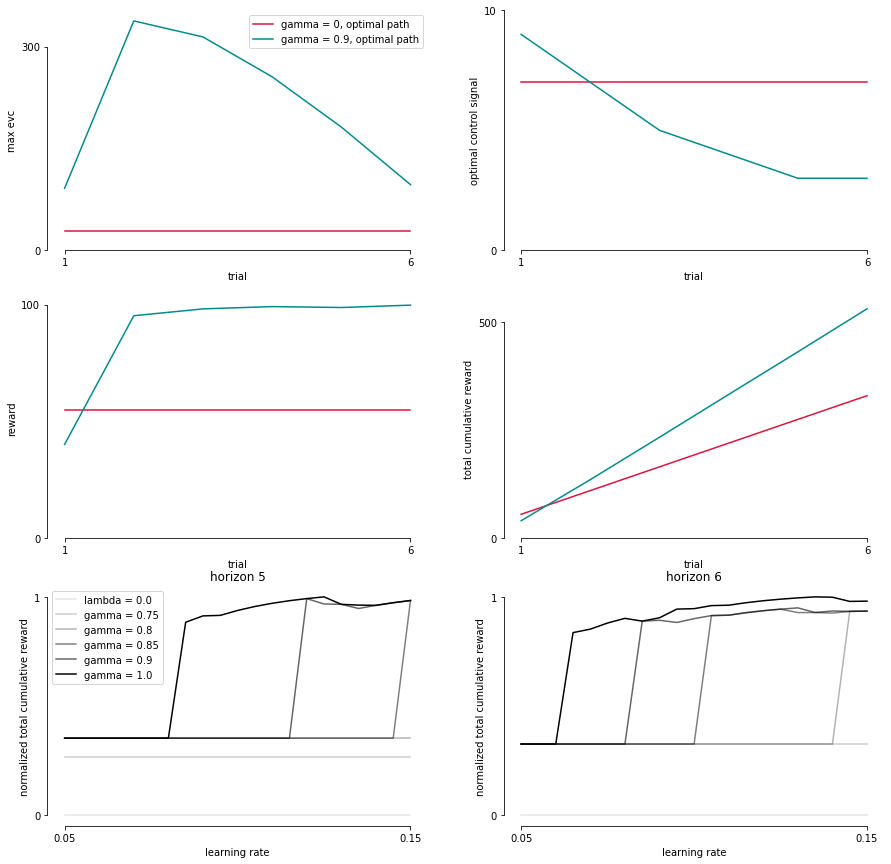

In [70]:
fig, ax = plt.subplots(3,2, figsize = (15, 15))

S_idx = opt_task_choice_array_idx_zerogamma
L_idx = opt_task_choice_array_idx

# ~~~~~~~~~~~~~ Panel (0,0) ~~~~~~~~~~~~~

ax[0,0].plot(max_evcs_zerogamma[S_idx,:], c = 'crimson', label = f'gamma = 0, optimal path')
ax[0,0].plot(max_evcs[L_idx,:], c = 'darkcyan', label = f'gamma = 0.9, optimal path')
ax[0,0].set_xticks([0,len(max_evcs[0,:])-1])
ax[0,0].set_xticklabels([1,len(max_evcs[-1,:])])
ax[0,0].set_yticks([0,300])
ax[0,0].set_xlabel('trial')
ax[0,0].set_ylabel('max evc')
ax[0,0].legend()

# ~~~~~~~~~~~~~ Panel (0,1) ~~~~~~~~~~~~~

ax[0,1].plot(opt_signals_zerogamma[S_idx,:], c = 'crimson')
ax[0,1].plot(opt_signals[L_idx,:], c = 'darkcyan')
ax[0,1].set_xticks([0,len(opt_signals[0,:])-1])
ax[0,1].set_xticklabels([1,len(opt_signals[0,:])])
ax[0,1].set_yticks([0,10])
ax[0,1].set_xlabel('trial')
ax[0,1].set_ylabel('optimal control signal')

# ~~~~~~~~~~~~~ Panel (1,0) ~~~~~~~~~~~~~

ax[1,0].plot(expected_reward_task0_zerogamma, c = 'crimson')
ax[1,0].plot(expected_reward_task1, c = 'darkcyan')
ax[1,0].set_xticks([0,len(max_evcs[0,:])-1])
ax[1,0].set_xticklabels([1,len(max_evcs[-1,:])])
ax[1,0].set_yticks([0,100])
ax[1,0].set_xlabel('trial')
ax[1,0].set_ylabel('reward')


# ~~~~~~~~~~~~~ Panel (1,1) ~~~~~~~~~~~~~

ax[1,1].plot(expected_cum_reward_task0_zerogamma, c = 'crimson')
ax[1,1].plot(expected_cum_reward_task1, c = 'darkcyan')
ax[1,1].set_xticks([0,len(max_evcs[0,:])-1])
ax[1,1].set_xticklabels([1,len(max_evcs[-1,:])])
ax[1,1].set_yticks([0,500])
ax[1,1].set_xlabel('trial')
ax[1,1].set_ylabel('total cumulative reward')

# ~~~~~~~~~~~~~ Panel (2,0) ~~~~~~~~~~~~~

ax[2,0].plot(learning_rates, total_rew_horizon5[0,:], c = 'k', alpha = 0.1, label = f'lambda = {discount_factors[0]}')
ax[2,0].plot(learning_rates, total_rew_horizon5[1,:], c = 'k', alpha = 0.2, label = f'gamma = {discount_factors[1]}')
ax[2,0].plot(learning_rates, total_rew_horizon5[2,:], c = 'k', alpha = 0.3, label = f'gamma = {discount_factors[2]}')
ax[2,0].plot(learning_rates, total_rew_horizon5[3,:], c = 'k', alpha = 0.5, label = f'gamma = {discount_factors[3]}')
ax[2,0].plot(learning_rates, total_rew_horizon5[4,:], c = 'k', alpha = 0.6, label = f'gamma = {discount_factors[4]}')
ax[2,0].plot(learning_rates, total_rew_horizon5[5,:], c = 'k', label = f'gamma = {discount_factors[5]}')
ax[2,0].set_yticks([0,1])
ax[2,0].set_xticks([0.05, 0.15])
ax[2,0].set_xlabel('learning rate')
ax[2,0].set_ylabel('normalized total cumulative reward')
ax[2,0].legend()
ax[2,0].set_title('horizon 5')

# ~~~~~~~~~~~~~ Panel (2,1) ~~~~~~~~~~~~~

ax[2,1].plot(learning_rates, total_rew_horizon6[0,:], c = 'k', alpha = 0.1, label = f'lambda = {discount_factors[0]}')
ax[2,1].plot(learning_rates, total_rew_horizon6[1,:], c = 'k', alpha = 0.2, label = f'gamma = {discount_factors[1]}')
ax[2,1].plot(learning_rates, total_rew_horizon6[2,:], c = 'k', alpha = 0.3, label = f'gamma = {discount_factors[2]}')
ax[2,1].plot(learning_rates, total_rew_horizon6[3,:], c = 'k', alpha = 0.5, label = f'gamma = {discount_factors[3]}')
ax[2,1].plot(learning_rates, total_rew_horizon6[4,:], c = 'k', alpha = 0.6, label = f'gamma = {discount_factors[4]}')
ax[2,1].plot(learning_rates, total_rew_horizon6[5,:], c = 'k', label = f'gamma = {discount_factors[5]}')
ax[2,1].set_yticks([0,1])
ax[2,1].set_xticks([0.05, 0.15])
ax[2,1].set_xlabel('learning rate')
ax[2,1].set_ylabel('normalized total cumulative reward')
ax[2,1].set_title('horizon 6')


# ~~~~~~~~~~~~~ General Figure Settings ~~~~~~~~~~~~~

sns.despine(trim=True)
fig.savefig('./fig_valueoflearning.pdf')
fig.show()

## Figure 4: Modified COGED Task Simulation

##### stored values to avoid running lengthy simulation

In [140]:
difficulties = np.linspace(0.2,0.6,9)
learning_rates = np.array([0, 0.075, 0.15])

# horizon = 4
subj_val_h4_df09_lr0 = np.array([100.,  70.,  65.,  65.,  65.,  65.,  65.,  65.,  65.]) # learning rate = 0
subj_val_h4_df09_lr0075 = np.array([190., 120.,  80.,  70.,  65.,  65.,  65.,  65.,  65.]) # learning rate = 0.075
subj_val_h4_df09_lr015 = np.array([215., 145., 100.,  85.,  75.,  70.,  70.,  65.,  65.]) # learning rate = 0.15

# horizon = 5
subj_val_h5_df09_lr0 = np.array([100.,  70.,  65.,  65.,  65.,  65.,  65.,  65.,  65.]) # learning rate = 0
subj_val_h5_df09_lr0075 = np.array([215., 135.,  90.,  70.,  65.,  65.,  65.,  65.,  65.]) # learning rate = 0.075
subj_val_h5_df09_lr015 = np.array([235., 170., 115.,  90.,  80.,  75.,  70.,  70.,  65.]) # learning rate = 0.15

# horizon = 6
subj_val_h6_df09_lr0 = np.array([100., 70., 65., 65., 65., 65., 65., 65., 65.])
subj_val_h6_df09_lr0075 = np.array([235., 150.,  95.,  75.,  70.,  65.,  65.,  65.,  65.])
subj_val_h6_df09_lr015 = np.array([260., 185., 130., 100.,  85.,  80.,  75.,  70.,  65.])

# discount factor = 0.8
subj_val_h6_df08_lr015 = np.array([230., 160., 110.,  90.,  80.,  75.,  70.,  70.,  65.])

# discount factor = 1.0
subj_val_h6_df1_lr015 = np.array([285., 210., 150., 115.,  95.,  85.,  75.,  75.,  70.])

##### if you'd like to run the simulation anyway

In [139]:
horizon = 4

task0_difficulty = np.full(horizon, 0.2)
task0_base_automaticity = 0.1

# learning_rates = np.array([0, 0.075, 0.15])
# difficulties = np.array([0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5])
# rewards = np.array([30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250])

learning_rates = np.array([0, 0.075, 0.15])
#     difficulties = np.array([0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5])
difficulties = np.linspace(0.2,0.6,9)
#     rewards = np.array([30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250])
rewards = np.linspace(0,300,61)

all_diff_rew = np.zeros((len(rewards), len(difficulties)), dtype = float)
diff_rew = np.zeros((len(learning_rates),len(difficulties)), dtype = float)

for l, learn in enumerate(learning_rates):
    tic = time.perf_counter()
    task1_learning_rate = learn
    print(f'task1_learning_rate= {task1_learning_rate}...')
    for d, diff in enumerate(difficulties):
        task1_difficulty = np.full(horizon, diff)
#         print(f'task1_difficulty = {task1_difficulty}...')
        for r, rew in enumerate(rewards):
            task0_reward = np.full(horizon, rew)
            opt_signals_coged, max_evcs_coged, all_evcs_coged = dense_evc(horizon, parallelize = True, cores = 32)
            opt_task_choice_array_coged, opt_task_choice_array_idx_coged = find_opt_task_choice_array(max_evcs_coged)
    #         print(f'diff = {diff}, rew = {rew}, opt_task_choice_array = {opt_task_choice_array}')
            all_diff_rew[r,d] = rew
#             print(f'reward = {rew}, opt array = {opt_task_choice_array_coged}')
            if opt_task_choice_array_coged[0] == 0:
    #             diff_rew[d] = rew
                diff_rew[l,d] = rew
                break
    toc = time.perf_counter()
    elapsed_time = toc - tic
    print(f'elapsed time: {elapsed_time:.04f} s')
        
print(diff_rew)

task1_learning_rate= 0.0...
elapsed time: 74.2833 s
task1_learning_rate= 0.075...
elapsed time: 92.2788 s
task1_learning_rate= 0.15...
elapsed time: 104.3510 s
[[100.  70.  65.  65.  65.  65.  65.  65.  65.]
 [190. 120.  80.  70.  65.  65.  65.  65.  65.]
 [215. 145. 100.  85.  75.  70.  70.  65.  65.]]


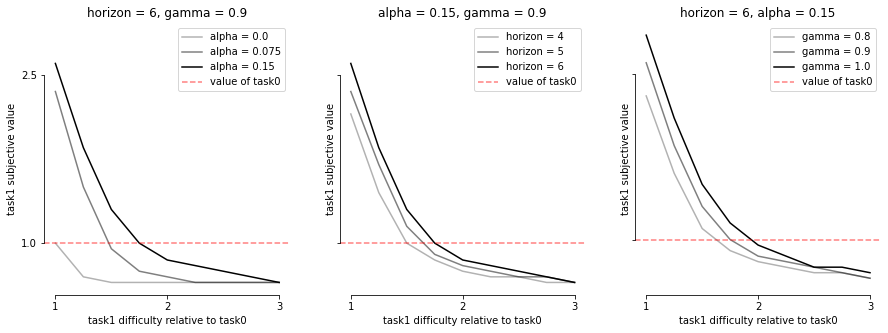

In [151]:
scaled_difficulties = difficulties/task0_difficulty[0]

fig, ax = plt.subplots(1,3, sharey = True, figsize = (15,5))

# ax[0,0].plot(scaled_difficulties, subj_val_h6_df09_lr0/task0_reward[0], c = 'k', alpha = 0.2, label = f'alpha = {learning_rates[0]}')
# ax[0,0].plot(scaled_difficulties, subj_val_h6_df09_lr0075/task0_reward[0], c = 'k', alpha = 0.2, label = f'alpha = {learning_rates[1]}')
# ax[0,0].plot(scaled_difficulties, subj_val_h6_df09_lr015/task0_reward[0], c = 'k', alpha = 0.2, label = f'alpha = {learning_rates[2]}')
# ax[0,0].set_xticks(scaled_difficulties)
# ax[0,0].set_yticks[0, 0.5, 1, 1.5, 2, 2.5]

# different learning rates

ax[0].plot(scaled_difficulties, subj_val_h6_df09_lr0/task1_reward[0], c = 'k', alpha = 0.3, label = f'alpha = {learning_rates[0]}')
ax[0].plot(scaled_difficulties, subj_val_h6_df09_lr0075/task1_reward[0], c = 'k', alpha = 0.5, label = f'alpha = {learning_rates[1]}')
ax[0].plot(scaled_difficulties, subj_val_h6_df09_lr015/task1_reward[0], c = 'k', alpha = 1, label = f'alpha = {learning_rates[2]}')
ax[0].axhline(1, c = 'r', linestyle = '--', alpha = 0.5, label = 'value of task0')
# ax[0].set_xticks(scaled_difficulties)
ax[0].set_xticks([1,2,3])
# ax[0].set_yticks([0.5, 1, 1.5, 2, 2.5])
ax[0].set_yticks([0.5, 1, 2.5])
ax[0].set_xlabel('task1 difficulty relative to task0')
ax[0].set_ylabel('task1 subjective value')
ax[0].legend()
ax[0].set_title('horizon = 6, gamma = 0.9')

# different horizons

ax[1].plot(scaled_difficulties, subj_val_h4_df09_lr015/task1_reward[0], c = 'k', alpha = 0.3, label = f'horizon = 4')
ax[1].plot(scaled_difficulties, subj_val_h5_df09_lr015/task1_reward[0], c = 'k', alpha = 0.5, label = f'horizon = 5')
ax[1].plot(scaled_difficulties, subj_val_h6_df09_lr015/task1_reward[0], c = 'k', alpha = 1, label = f'horizon = 6')
ax[1].axhline(1, c = 'r', linestyle = '--', alpha = 0.5, label = 'value of task0')
# ax[1].set_xticks(scaled_difficulties)
ax[1].set_xticks([1,2,3])
# ax[1].set_yticks([0.5, 1, 1.5, 2, 2.5])
ax[1].set_yticks([0.5, 1, 2.5])
ax[1].set_xlabel('task1 difficulty relative to task0')
ax[1].set_ylabel('task1 subjective value')
ax[1].legend()
ax[1].set_title('alpha = 0.15, gamma = 0.9')

# different discount factors

ax[2].plot(scaled_difficulties, subj_val_h6_df08_lr015/task1_reward[0], c = 'k', alpha = 0.3, label = f'gamma = 0.8')
ax[2].plot(scaled_difficulties, subj_val_h6_df09_lr015/task1_reward[0], c = 'k', alpha = 0.5, label = f'gamma = 0.9')
ax[2].plot(scaled_difficulties, subj_val_h6_df1_lr015/task1_reward[0], c = 'k', alpha = 1, label = f'gamma = 1.0')
ax[2].axhline(1, c = 'r', linestyle = '--', alpha = 0.5, label = 'value of task0')
# ax[2].set_xticks(scaled_difficulties)
ax[2].set_xticks([1,2,3])
# ax[2].set_yticks([0.5, 1, 1.5, 2, 2.5])
ax[2].set_yticks([0.5, 1, 2.5])
ax[2].set_xlabel('task1 difficulty relative to task0')
ax[2].set_ylabel('task1 subjective value')
ax[2].legend()
ax[2].set_title('horizon = 6, alpha = 0.15')

sns.despine(trim = True)
fig.savefig('fig_lcoged_simulation.pdf')
fig.show()

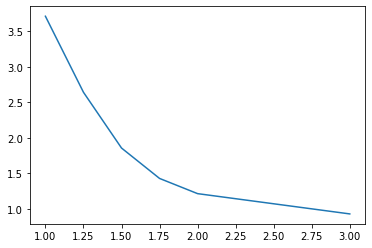

In [124]:
plt.plot(scaled_difficulties, subj_val_h6_df09_lr015/task0_reward[0])

In [125]:
task0_reward[0]

70

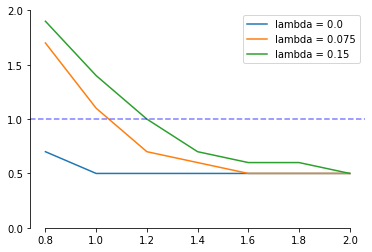

In [82]:
scaled_difficulties = difficulties/task0_difficulty[0]

plt.plot(scaled_difficulties, diff_rew[0,:]/100, label = f'lambda = {learning_rates[0]}')
plt.plot(scaled_difficulties, diff_rew[1,:]/100, label = f'lambda = {learning_rates[1]}')
plt.plot(scaled_difficulties, diff_rew[2,:]/100, label = f'lambda = {learning_rates[2]}')
# plt.axvline(0.20, c = 'b', linestyle = '--', alpha = 0.5)
plt.axhline(1, c = 'b', linestyle = '--', alpha = 0.5)
plt.xticks(scaled_difficulties)
plt.yticks([0, 0.5, 1, 1.5, 2])
sns.despine(trim = True)
plt.legend()

In [75]:
# [[ 70.  50.  50.  50.  50.  50.  50.]
#  [170. 110.  70.  50.  50.  50.  50.]

array([0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ])

In [99]:
np.linspace(0.2,0.6,9)

array([0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ])